## Run 3 basic mvp models to predict demand using price,population,gdp,holidays and timeseries features. 

**Preprocessing**

**Feature creation**

**Models (train/test split, evaluation metrics, feature importances)**

* Xgboost 
* RNN
* Facebook prophet


In [2]:
##Library Imports 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Define a pallette for the plots

colour_palette = sns.color_palette()
plt.rcParams['axes.grid'] = True

python(92989) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [3]:
## Read the merged data file 

df = pd.read_csv('cleaned_data/all_data.csv')

In [4]:
print(df.head())
print(df.tail())

              DateTime  Ontario Demand   HOEP    Population            GDP  \
0  2002-05-01 00:00:00         14137.0  22.97  11261.890411  502402.719512   
1  2002-05-01 01:00:00         13872.0  23.27  11261.884817  502407.844512   
2  2002-05-01 02:00:00         13820.0  24.54  11261.879224  502412.969512   
3  2002-05-01 03:00:00         13744.0  15.17  11261.873630  502418.094512   
4  2002-05-01 04:00:00         14224.0  23.59  11261.868037  502423.219512   

   Holiday  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
                   DateTime  Ontario Demand   HOEP  Population           GDP  \
191227  2024-02-22 19:00:00         17991.0  41.37     11732.0  1.109115e+06   
191228  2024-02-22 20:00:00         17636.0  48.66     11732.0  1.109115e+06   
191229  2024-02-22 21:00:00         17138.0  30.30     11732.0  1.109115e+06   
191230  2024-02-22 22:00:00         16265.0  27.78     11732.0  1.109115e+06   
191231  2024-02-22 23:00:00             NaN  25.62   

In [5]:
## Data inspection

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191232 entries, 0 to 191231
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DateTime        191232 non-null  object 
 1   Ontario Demand  190370 non-null  float64
 2   HOEP            191224 non-null  float64
 3   Population      191232 non-null  float64
 4   GDP             191232 non-null  float64
 5   Holiday         190370 non-null  float64
dtypes: float64(5), object(1)
memory usage: 8.8+ MB


In [6]:
## Turn the date column into a datetime object

df['DateTime'] = pd.to_datetime(df['DateTime'])
# Set 'DateTime' column as the index
df.set_index('DateTime', inplace=True)



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191232 entries, 2002-05-01 00:00:00 to 2024-02-22 23:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Ontario Demand  190370 non-null  float64
 1   HOEP            191224 non-null  float64
 2   Population      191232 non-null  float64
 3   GDP             191232 non-null  float64
 4   Holiday         190370 non-null  float64
dtypes: float64(5)
memory usage: 8.8 MB


In [8]:
# Calculate the number of missing values for each column
missing_values = df.isnull().sum()

# Calculate the percentage of missing values for each column
percentage_missing = (missing_values / len(df)) * 100

# Combine the results into a DataFrame for easier visualization
missing_data_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': percentage_missing})

# Print the missing data summary
print(missing_data_summary)


                Missing Values  Percentage
Ontario Demand             862    0.450761
HOEP                         8    0.004183
Population                   0    0.000000
GDP                          0    0.000000
Holiday                    862    0.450761


In [9]:
## In this first iteration will just fill those missing values with the mean, since the % of missing values is low (Iteration 2 and 3 will investigate further and the solution will be more complex)

# Calculate the mean of each column
mean_ontario_demand = df['Ontario Demand'].mean()
mean_hoep = df['HOEP'].mean()
mean_holiday = df['Holiday'].mean()

# Impute missing values with the mean
df['Ontario Demand'].fillna(mean_ontario_demand, inplace=True)
df['HOEP'].fillna(mean_hoep, inplace=True)
df['Holiday'].fillna(mean_holiday, inplace=True)



In [10]:
# Calculate the number of missing values for each column
missing_values = df.isnull().sum()

# Calculate the percentage of missing values for each column
percentage_missing = (missing_values / len(df)) * 100

# Combine the results into a DataFrame for easier visualization
missing_data_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': percentage_missing})

# Print the missing data summary
print(missing_data_summary)


                Missing Values  Percentage
Ontario Demand               0         0.0
HOEP                         0         0.0
Population                   0         0.0
GDP                          0         0.0
Holiday                      0         0.0


### Time series features 

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [12]:
df.head()

,Ontario Demand,HOEP,Population,GDP,Holiday,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,,,,,
2002-05-01 00:00:00,14137.0,22.97,11261.890411,502402.719512,0.0,0,2,2,5,2002,121,1,18
2002-05-01 01:00:00,13872.0,23.27,11261.884817,502407.844512,0.0,1,2,2,5,2002,121,1,18
2002-05-01 02:00:00,13820.0,24.54,11261.879224,502412.969512,0.0,2,2,2,5,2002,121,1,18
2002-05-01 03:00:00,13744.0,15.17,11261.873630,502418.094512,0.0,3,2,2,5,2002,121,1,18
2002-05-01 04:00:00,14224.0,23.59,11261.868037,502423.219512,0.0,4,2,2,5,2002,121,1,18


In [13]:
print(df.columns)

Index(['Ontario Demand', 'HOEP', 'Population', 'GDP', 'Holiday', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')


## Model 

In [14]:
## Define Evaluation Metrics functions 

## Root mean square error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Mean absolute percentage error (MAPE)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Mean absolute error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [15]:
## Train test split

## Hold out the last 5 years for testing and 2002 to 2018 for training


train = df.loc['2002-05-01':'2018-12-31']
test = df.loc['2019-01-01':]



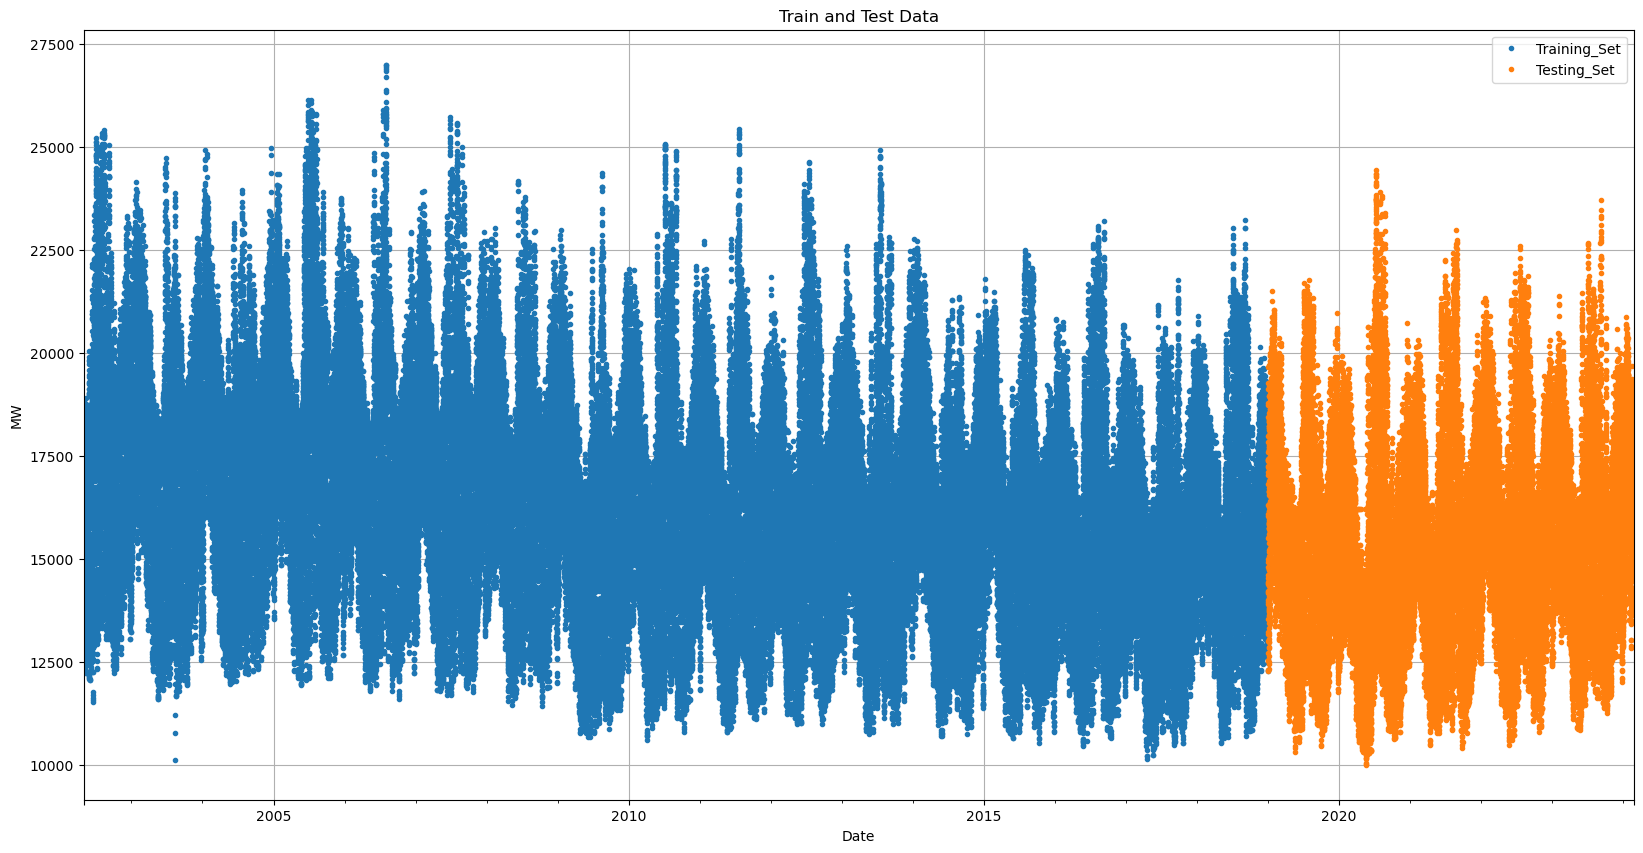

In [16]:
#Visualize the train and test data on the same plot to visulize the split using matplotlib subplots 


demand_train = train['Ontario Demand']
demand_test = test['Ontario Demand']


#Instantiate the figure
fig,ax = plt.subplots(figsize = (20,10))
demand_train.plot(ax = ax, style = '.', label = 'Training_Set', color = colour_palette[0])
demand_test.plot(ax = ax, style = '.', label = 'Testing_Set', color = colour_palette[1])
ax.set_title('Train and Test Data')
ax.legend(['Training_Set','Testing_Set'])
plt.xlabel('Date')
plt.ylabel('MW')

#Plot the figure
plt.show()

In [17]:
## Define the features and target variable  

target = ['Ontario Demand']

features = ['HOEP', 'Population', 'GDP', 'Holiday', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear']




In [18]:
## Split the data into X and y

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]



In [19]:
## Shapes of the data

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(146136, 12)
(146136, 1)
(45096, 12)
(45096, 1)


In [20]:
## Instantiate the XGBoost Regressor

regression = xgb.XGBRegressor(n_estimators = 500,  early_stopping_rounds = 50, learning_rate = 0.01)
regression.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 50)



[0]	validation_0-rmse:2587.39191	validation_1-rmse:2498.86545
[50]	validation_0-rmse:1867.07430	validation_1-rmse:1917.82025
[100]	validation_0-rmse:1478.74094	validation_1-rmse:1631.21003
[150]	validation_0-rmse:1259.16338	validation_1-rmse:1483.15890
[200]	validation_0-rmse:1116.69650	validation_1-rmse:1393.14479
[250]	validation_0-rmse:1021.49114	validation_1-rmse:1334.29057
[300]	validation_0-rmse:949.70987	validation_1-rmse:1278.63581
[350]	validation_0-rmse:898.17414	validation_1-rmse:1236.84615
[400]	validation_0-rmse:858.66778	validation_1-rmse:1205.54469
[450]	validation_0-rmse:828.82307	validation_1-rmse:1185.38845
[499]	validation_0-rmse:806.21204	validation_1-rmse:1169.20974


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

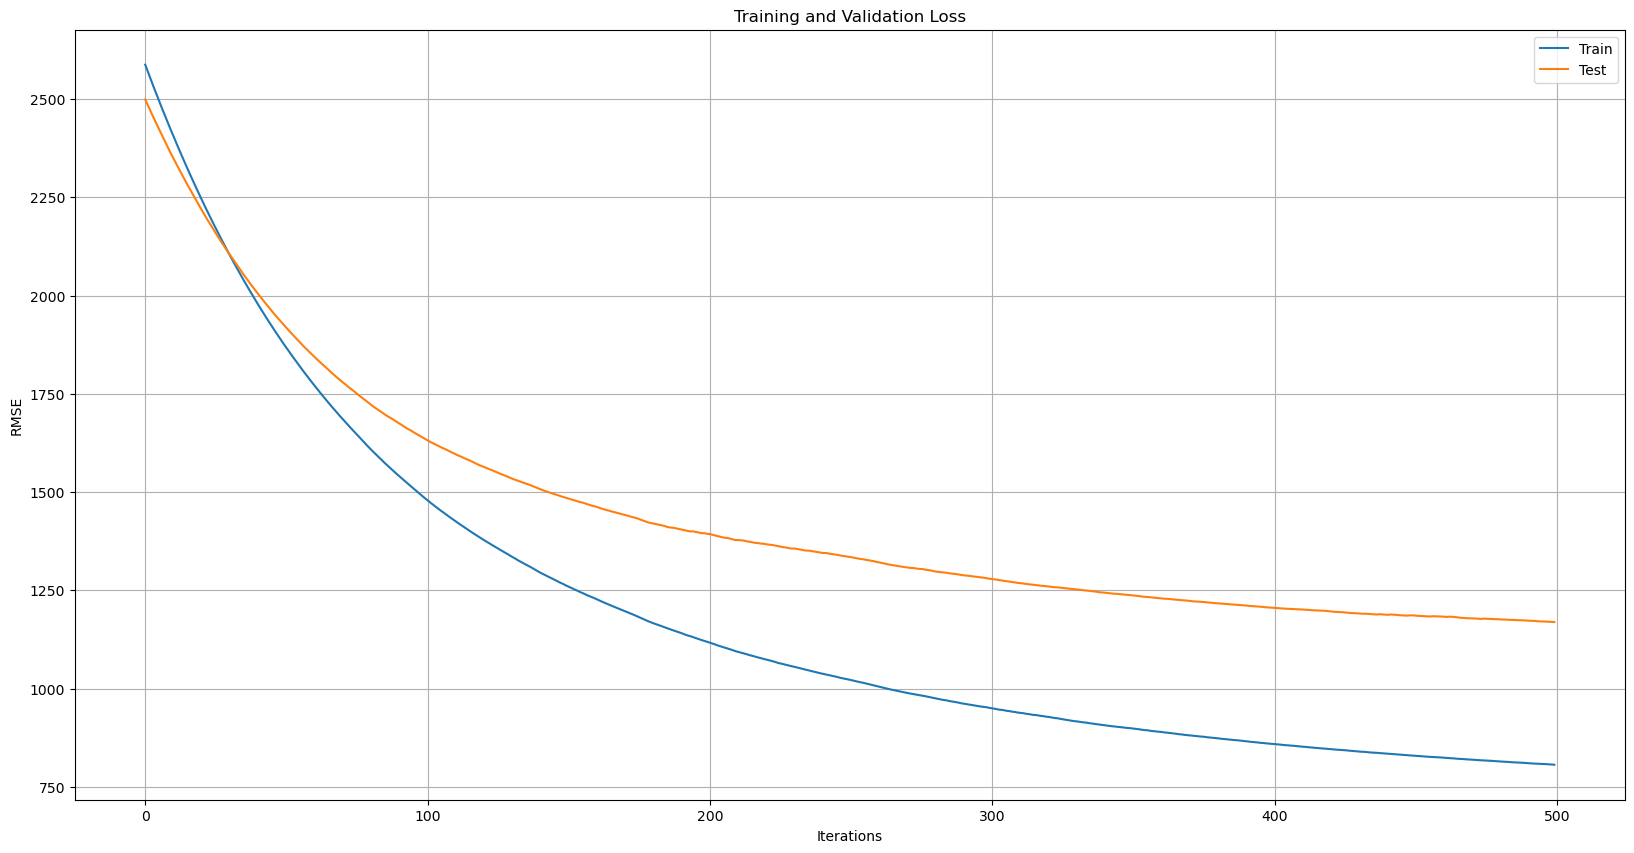

In [21]:
## Training and validation loss plot 

results = regression.evals_result()

train_rmse = results['validation_0']['rmse']
test_rmse = results['validation_1']['rmse']

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(train_rmse, label = 'Train')
ax.plot(test_rmse, label = 'Test')

ax.set_title('Training and Validation Loss')
ax.legend(['Train_Loss','Test_loss'])

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.show()

As seen from the plot the model is overfitting. However it is good for this iteration and will be used to predict the 1 week, and 5 max peak demands. The model will be imporoved iteratively throughout this project. 

In [22]:
## Predict the test data
y_pred = regression.predict(X_test)
y_pred = y_pred.reshape(-1, 1)

## Flaten both the predicted and actual values

# y_pred = y_pred.flatten()
# # y_test = y_test.to_numpy()
# y_test = y_test.flatten()


## Data frame of actual and predicted values


In [23]:
y_pred = y_pred.reshape(-1, 1)
y_pred = y_pred.flatten()
y_test = y_test.to_numpy()
y_test = y_test.flatten()
print(y_pred.shape)
print(y_test.shape)

(45096,)
(45096,)


In [24]:

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results.head(10)

,Actual,Predicted
0,13198.0,14184.767578
1,12737.0,14032.144531
2,12531.0,13846.576172
3,12291.0,13815.146484
4,12305.0,13796.181641
5,12559.0,13807.400391
6,13009.0,13310.804688
7,13234.0,14303.249023
8,13558.0,15223.902344
9,13973.0,15446.207031


In [25]:
print('RMSE:', rmse(y_test, y_pred))
print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))


RMSE: 1169.2097398986448
MAE: 881.469453514244
MAPE: 5.718314381977631


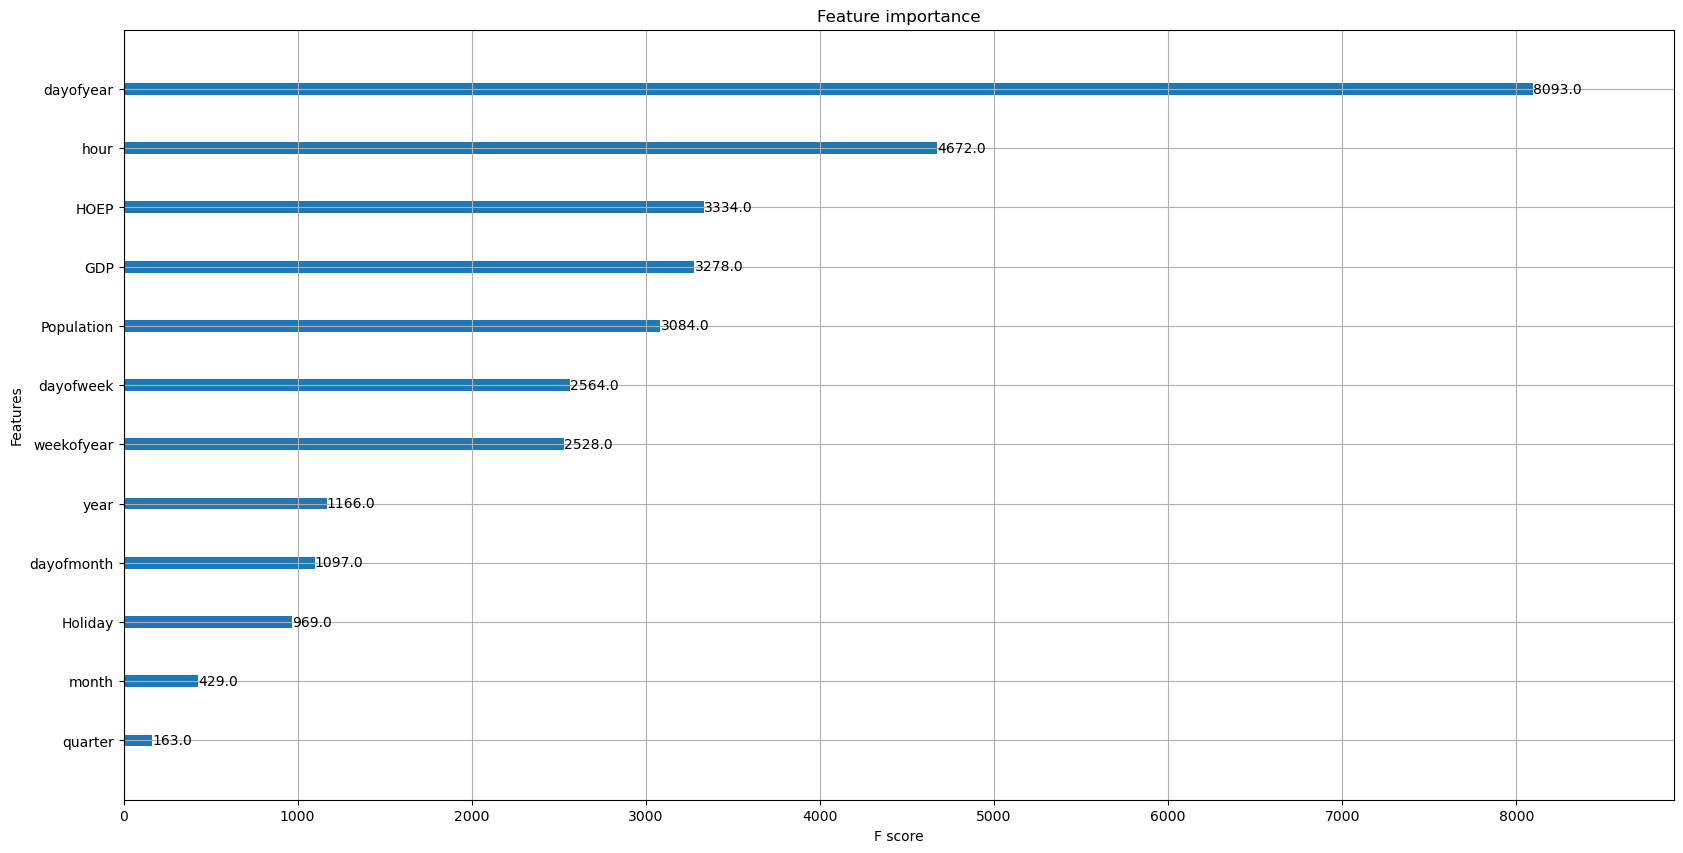

In [26]:
## Feature importance plot

fig, ax = plt.subplots(figsize = (20,10))
xgb.plot_importance(regression, ax = ax)
plt.show()


#### Xgboost model prediction on the next 6 days sending data to google looker studio 



In [27]:
## Save the model 

import pickle


## Save the model to disk

filename = 'xgboost_model(1).sav'
pickle.dump(regression, open(filename, 'wb'))





In [28]:
## Load the model from disk

loaded_model = pickle.load(open(filename, 'rb'))


#### RNN Model 

In [57]:
## Rnn and LSTM imports 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [30]:
df.head()

,Ontario Demand,HOEP,Population,GDP,Holiday,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,,,,,
2002-05-01 00:00:00,14137.0,22.97,11261.890411,502402.719512,0.0,0,2,2,5,2002,121,1,18
2002-05-01 01:00:00,13872.0,23.27,11261.884817,502407.844512,0.0,1,2,2,5,2002,121,1,18
2002-05-01 02:00:00,13820.0,24.54,11261.879224,502412.969512,0.0,2,2,2,5,2002,121,1,18
2002-05-01 03:00:00,13744.0,15.17,11261.873630,502418.094512,0.0,3,2,2,5,2002,121,1,18
2002-05-01 04:00:00,14224.0,23.59,11261.868037,502423.219512,0.0,4,2,2,5,2002,121,1,18


In [31]:
## Normailze the data 


## Scale the data
column_names = df.columns 
x = df.values #returns.values numpy array (.to_numpy() also works)
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=column_names, index = df.index)


In [32]:
df.head()

,Ontario Demand,HOEP,Population,GDP,Holiday,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,,,,,
2002-05-01 00:00:00,0.242569,0.089887,0.428091,0.000000,0.0,0.000000,0.333333,0.333333,0.363636,0.0,0.328767,0.0,0.326923
2002-05-01 01:00:00,0.226970,0.090054,0.428084,0.000008,0.0,0.043478,0.333333,0.333333,0.363636,0.0,0.328767,0.0,0.326923
2002-05-01 02:00:00,0.223910,0.090760,0.428077,0.000017,0.0,0.086957,0.333333,0.333333,0.363636,0.0,0.328767,0.0,0.326923
2002-05-01 03:00:00,0.219436,0.085553,0.428070,0.000025,0.0,0.130435,0.333333,0.333333,0.363636,0.0,0.328767,0.0,0.326923
2002-05-01 04:00:00,0.247690,0.090232,0.428063,0.000034,0.0,0.173913,0.333333,0.333333,0.363636,0.0,0.328767,0.0,0.326923


In [33]:
## df.shape

df.shape

(191232, 13)

In [34]:
## train/test split 

## Train 2022-05-01 to 2014-12-31
## Validation 2015-01-01 to 2020-12-31
## Test 2021-01-01 to 2024-02-22

train = df.loc['2002-05-01':'2014-12-31']
validation = df.loc['2015-01-01':'2020-12-31']
test = df.loc['2021-01-01':'2024-02-22']




In [38]:
## Dataframe shapes 

print(train.shape)
print(validation.shape)
print(test.shape)


(111072, 13)
(52608, 13)
(27552, 13)


In [46]:
## Split multi variate time series data into sequences

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(sequences):
            break
        seq_x = sequences.iloc[i:end_ix, :-1].values
        seq_y = sequences.iloc[end_ix:out_end_ix+1, -1].values
        # Check if the lengths of seq_x and seq_y are consistent
        if len(seq_x) == n_steps_in and len(seq_y) == n_steps_out:
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)



## Define a look back window and a forecasting window 

n_steps_in = 30
n_steps_out = 7



In [48]:
## Split the data into X and y

X_train, y_train = split_sequences(train, n_steps_in, n_steps_out)
X_val, y_val = split_sequences(validation, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test, n_steps_in, n_steps_out)




In [49]:

## Data Shapes

print(X_train.shape) 
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

# ## Shapes of test data 

print(X_test.shape)
print(y_test.shape)

(111036, 30, 12)
(111036, 7)
(52572, 30, 12)
(52572, 7)
(27516, 30, 12)
(27516, 7)


In [61]:
## All data types 

print(X_train.dtype)
print(y_train.dtype)

print(X_val.dtype)
print(y_val.dtype)

print(X_test.dtype)
print(y_test.dtype)


float64
float64
float64
float64
float64
float64


In [64]:
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError

# Define the metrics
mse = MeanSquaredError()
mae = MeanAbsoluteError()
mape = MeanAbsolutePercentageError()
rmse = RootMeanSquaredError()




In [65]:
## RNN Model Architecture

model = Sequential()
model.add(layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, 12)))
model.add(layers.LSTM(100, activation='relu'))
model.add(layers.Dense(n_steps_out))
model.add(Activation('linear'))
# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=[mae, mse, mape, rmse])


## Model Summary

model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 100)           45200     
                                                                 
 lstm_17 (LSTM)              (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 7)                 707       
                                                                 
 activation_3 (Activation)   (None, 7)                 0         
                                                                 
Total params: 126307 (493.39 KB)
Trainable params: 126307 (493.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
## Fit the model

model = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, batch_size = 64, verbose = 1, shuffle = False)


Epoch 1/100
  13/1735 [..............................] - ETA: 3:32:49 - loss: 0.0016 - mean_absolute_error: 0.0323 - mean_squared_error: 0.0016 - mean_absolute_percentage_error: 8.6386 - root_mean_squared_error: 0.0395

KeyboardInterrupt: 

In [ ]:
## Plot the training and validation loss

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(model.history['loss'], label = 'Train')
ax.plot(model.history['val_loss'], label = 'Validation')
ax.set_title('Training and Validation Loss')
ax.legend(['Train_Loss','Validation_loss'])
plt.xlabel('Iterations')
